In [1]:
import numpy as np
import ten
import ipywidgets as widgets
import matplotlib.pyplot as plt
%config InlineBackend.figure_formats = ["svg"]
import itertools



$$ m_i = \begin{pmatrix}
1 \\ -1
\end{pmatrix}
$$

In [2]:
temperature = widgets.FloatSlider(min=2, max=5)
temperature

FloatSlider(value=2.0, max=5.0, min=2.0)

In [3]:
D = widgets.IntSlider(value=8, min=8, max=24)
D

IntSlider(value=8, max=24, min=8)

In [4]:
steps = widgets.IntSlider(min=4, max=100)
steps

IntSlider(value=4, min=4)

In [5]:
def trace(t):
	return np.einsum("iijj->", t)

$$ Z = \sum_{i} e^{- \beta E_i} = \text{Tr} \prod_i T_{l_i r_i u_i d_i} $$

$$ T^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d}$$

$$ W_{ij} = \begin{pmatrix}
\sqrt{\cosh\left(\frac{1}{t}\right)} & \sqrt{\sinh\left(\frac{1}{t}\right)} \\
\sqrt{\cosh\left(\frac{1}{t}\right)} & -\sqrt{\sinh\left(\frac{1}{t}\right)}
\end{pmatrix}
$$

$$ H^{(0)}_{lrud} = \sum_\alpha W_{\alpha,l} ~ W_{\alpha,r} ~ W_{\alpha,u} ~ W_{\alpha,d} ~ m_\alpha ~~~~ \text{where} ~~~~ m_\alpha = \begin{pmatrix} 1 \\ -1 \end{pmatrix} $$

$$ \text{Magnetization} = \frac{\text{Tr}(H)}{\text{Tr}(Z)} $$


$$ M^{(n)}_{lrud} = \sum_\alpha T^{(n-1)}_{l_1 r_1 u \alpha} T^{(n-1)}_{l_2 r_2 \alpha d} ~~~~ \text{where} ~~~~ l = l_1 \otimes l_2, ~~ r = r_1 \otimes r_2 $$

In [6]:
def M(u: np.ndarray, d: np.ndarray) -> np.ndarray:
	t = np.einsum("abci,deif->adbecf", u, d)
	return t.reshape((t.shape[0]*t.shape[1], t.shape[2]*t.shape[3], t.shape[4], t.shape[5]))


$$ M^{(n)}_{lrud} = \sum_{\alpha \beta \gamma \epsilon} S_{\alpha \beta \gamma \epsilon} U^L_{l,\alpha} U^R_{r,\beta} U^U_{u,\gamma} U^D_{d,\epsilon} $$

$$ \varepsilon_1 = \sum_{i > D} \vert S_{i,:,:,:} \vert^2, ~~~~ \varepsilon_2 = \sum_{j > D} \vert S_{:,j,:,:} \vert^2 $$

$$ \hat{U} = \begin{cases}
U^L, & \varepsilon_1 < \varepsilon_2 \\
U^R, & \text{otherwise}
\end{cases}
$$

$$ T^{(n)}_{lrud} = \sum_{\alpha \beta} \hat{U}_{l,\alpha} M^{(n)}_{\alpha \beta u d} \hat{U}_{r,\beta} $$

In [7]:
def one_iteration(H: np.ndarray, T: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
	# contract with environment
	Mt = M(T, T)
	Mh = M(H, T)

	# decompose tensor
	S, Us = ten.hosvd(Mt)

	eps1 = sum(np.sum(np.square(np.abs(S[i,:]))) for i in range(D.value, S.shape[0]))
	eps2 = sum(np.sum(np.square(np.abs(S[:,j,:]))) for j in range(D.value, S.shape[1]))
	U = Us[0 if eps1 < eps2 else 1]

	# truncate U
	if U.shape[1] > D.value:
		U = U[:, 0:D.value]
	U = U / np.sqrt(np.max(S))

	# new T, H
	T = np.einsum("il,ijud,jr->lrud", U, Mt, U)
	H = np.einsum("il,ijud,jr->lrud", U, Mh, U)

	return H, T

magnetization=0.0
n=0 -> magnetization=-1.4706399156722835e-16
n=1 -> magnetization=-2.182987775429992e-16
n=2 -> magnetization=-2.060611900680865e-16
n=3 -> magnetization=-6.350374545184161e-16
n=4 -> magnetization=-2.302281489441522e-15
n=5 -> magnetization=2.5705768583747284e-13
n=6 -> magnetization=-1.38066901114932e-07
n=7 -> magnetization=-3.220529773230175e-07
n=8 -> magnetization=-1.3323747054520665e-06
n=9 -> magnetization=-5.382177669556633e-06
n=10 -> magnetization=-2.1439598949776006e-05
n=11 -> magnetization=-8.548500050502416e-05
n=12 -> magnetization=-0.0003418040201442374
n=13 -> magnetization=-0.0013670814137613423
n=14 -> magnetization=-0.005468102551126625
n=15 -> magnetization=-0.021868169864091756
n=16 -> magnetization=-0.0872213194033771
n=17 -> magnetization=-0.3337082103108291
n=18 -> magnetization=-0.8305550556450876
n=19 -> magnetization=-0.9112041619905813
n=20 -> magnetization=-0.9112126556584457
n=21 -> magnetization=-0.9112127169289003
n=22 -> magnetizatio

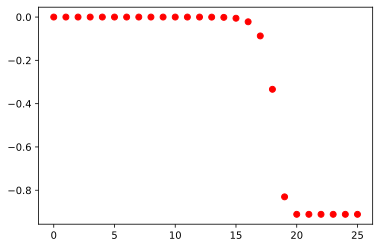

In [11]:
fig = plt.figure()
ax = fig.subplots(1)

T = ten.ising.partition_tensor(temperature.value)
H = ten.ising.magnetization(temperature.value)
magnetization = trace(H)/trace(T)

print(f"{magnetization=}")
ax.plot(0, magnetization, "ro")

for n in range(steps.value):
	for permutator in itertools.islice([(0,1,3,2), (2,3,0,1)], 4):
		H, T = one_iteration(H, T)
		# H = np.moveaxis(H, -1, 0)
		# T = np.moveaxis(T, -1, 0)
		H = H.transpose(permutator)
		T = T.transpose(permutator)

	magnetization = trace(H)/trace(T)
	print(f"{n=} -> {magnetization=}")
	ax.plot(n+1, magnetization, "ro")

magnetization=0.0
n=0
norm(S)=11.501380920410156
t -> eps1=0, eps2=0
magnetization=-4.465559395702669e-17

n=1
norm(S)=2.2149479389190674
t -> eps1=0, eps2=0
magnetization=-1.942277415634234e-17

n=2
norm(S)=3.1615400314331055
t -> eps1=1.2987334223331573, eps2=1.298733400223533
magnetization=-5.5302050529112035e-17

n=3
norm(S)=5.05368709564209
t -> eps1=10.35821004922036, eps2=10.3582099332707
magnetization=6.532766430967852e-17

n=4
norm(S)=7.828759670257568
t -> eps1=39.605626702308655, eps2=39.60562541335821
magnetization=7.876220907594942e-18

n=5
norm(S)=17.304370880126953
t -> eps1=229.35591450333595, eps2=229.35591243207455
magnetization=5.89916933719934e-17

n=6
norm(S)=12.155716896057129
t -> eps1=121.72645854949951, eps2=121.72645735740662
magnetization=-1.9404878774048069e-16

n=7
norm(S)=13.121087074279785
t -> eps1=146.3912964463234, eps2=146.39129620790482
magnetization=-5.923821055818416e-16

n=8
norm(S)=13.443092346191406
t -> eps1=155.1705228984356, eps2=155.17052108

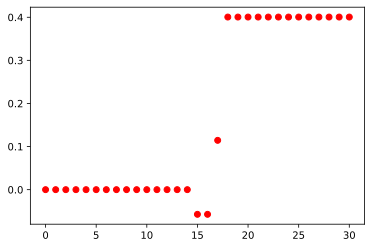

In [29]:
fig = plt.figure()
ax = fig.subplots(1)

T = ten.ising.partition_tensor(temperature.value)
H = ten.ising.magnetization(temperature.value)
magnetization = trace(H)/trace(T)

print(f"{magnetization=}")
ax.plot(0, magnetization, "ro")

for n in range(steps.value):
	print(f"{n=}")

	# contract with environment
	Mt = M(T, T)
	Mh = M(H, T)

	# decompose tensor
	S, Us = ten.hosvd(Mt)

	eps1 = sum(np.sum(np.square(np.abs(S[i,:]))) for i in range(D.value, S.shape[0]))
	eps2 = sum(np.sum(np.square(np.abs(S[:,j,:]))) for j in range(D.value, S.shape[1]))
	print(f"t -> {eps1=}, {eps2=}")
	U = Us[0 if eps1 < eps2 else 1]

	# truncate U
	if U.shape[1] > D.value:
		U = U[:, 0:D.value]
	U = U / np.sqrt(np.max(S)) # np.sqrt(np.linalg.norm(S))

	# new T, H
	T = np.einsum("il,ijud,jr->lrud", U, Mt, U)
	H = np.einsum("il,ijud,jr->lrud", U, Mh, U)

	magnetization = trace(H)/trace(T)

	print(f"{magnetization=}")
	ax.plot(n+1, magnetization, "ro")

	print()